In [5]:
#Python Packages & Statistics
import pandas as pd
import numpy as np
import math
from itertools import compress

#Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

#RDKit
from rdkit import Chem
from rdkit.Chem import PandasTools
#Saving to Excel
from openpyxl import load_workbook
from helper_functions import *
plt.rcParams['figure.figsize'] = [20,10]

print('Imports Done')
#Load in Data
scaffold_names = ['CYCLOHEXANE', 'CYCLOPENTANE', 'PIPERIDINE', 'PYRROLIDINE', 'PYRROLE', 'PYRAZOLE','IMIDAZOLE', 'NAPHTHALENE', 'INDAZOLE', 'INDOLE', 'TETRAHYDROPYRANE', 'FURAN', 'TETRAHYDROFURAN', 'PYRIDINE', 'BENZENE', 'TRIAZOLE']
comprehensive_data = {'1200':{'Compound_#':[], 'Smiles':[], 'MOL':[], 'logReact':[], 'mtb':[], 'msm':[], 'has_ring':[], 'scaffolds':{}, 'fused':{}, 'non_fused':{}, 'props':{}}, 
                      '380':{'Compound_#':[], 'Smiles':[], 'MOL':[], 'logReact':[], 'mtb':[], 'msm':[], 'has_ring':[], 'scaffolds':{}, 'fused':{}, 'non_fused':{}, 'props':{}},
                      '40':{'Compound_#':[], 'Smiles':[], 'MOL':[], 'logReact':[], 'mtb':[], 'msm':[], 'has_ring':[], 'scaffolds':{}, 'fused':{}, 'non_fused':{}, 'props':{}}
                      }
msm_380 = pd.read_excel('380 library Msm whole cell final correction.xlsx', index_col=None, usecols="A,C,H,J")
mtb_380 = pd.read_csv('380_raw.csv', usecols=["#", "Smiles", "Mtb AVERAGE", "PS-DBCO "])
props_380 = pd.read_csv('380_props.csv')
props_40 = pd.read_csv('40_props.csv')
props_1200 = pd.read_csv('1200_props.csv')
print(props_1200.columns)
print(props_380.columns)
print(props_40.columns)
new_40 = pd.read_csv('20240719 Mtb and Msm az-40 data DEF for Turner.csv')
comp_data_1200 = pd.read_excel('20240516 Only MEAN - for CDD 1200 and 380.xlsx', index_col=None, usecols="G,F,H,I,J")

#Set up dataframe

#Combine 380 data
params = Chem.SmilesParserParams()
params.removeHs = True
smiles = '[H]N1C2=CC=CC=C2C=C1.[H]N1C2=NC=NC=C2N=C1.C1=CC=C2C(=C1)C=NN2.[H]N1C2=CC=CC=C2C=N1.C1=CC=C2C(=C1)C=CN2.CN1N=CC=C1.CN%12C=CC=C%12.CN%13C=CN=N%13.C%14%15=CC=CC=C%14OCO%15.C%16%17=CC=CC=C%16C=CC=C%17.C%18=CC=CO%18.C%19=CC=CS%19.C%20=CC=CN%20.C%21CCCCC%21.C%22CCCC%22.N%23CCCCC%23.N%24CCCC%24.C%25=CC=NO%25.N%26=NC=CN%26.C%27CC%27.C%28=CC=NN%28.O%29CCCCC%29.S%30CCCCC%30.O%31CCCC%31.O1C2=CC=CC=C2C=C1.C12=NC=CN1C=CC=C2.C1=CC=NC=N1.C12=NC=CC=C1NC=C2.CN1C=CC2=NC=CC=C21.C1=CN=CN1.'.split('.')
new_smiles = ['C1CCCCC1',
              'C1CCCC1',
              'N1CCCCC1',
              'N1CCCC1',
              'C1=CC=CN1',
              'C1=CC=NN1',
              'C1=NC=CN1',
              'C12=CC=CC=C1C=CC=C2',
              'C1=CC=C2C(=C1)C=NN2',
              'C1=CC2=CC=CC=C2N1',
              'C1CCCOC1',
              'C1=CC=CO1',
              'O1CCCC1',
              'C1=CC=CC=N1',
              'C1=CC=CC=C1',
              'N1=NC=CN1'
              ]
substruct_patterns = {scaffold_names[i]: Chem.MolFromSmiles(new_smiles[i]) for i in range(len(new_smiles))}
for (key, mol) in substruct_patterns.items():
    column_name = key
    comprehensive_data['380']['scaffolds'][column_name] = []
    comprehensive_data['1200']['scaffolds'][column_name] = []
    comprehensive_data['40']['scaffolds'][column_name] = []
    comprehensive_data['380']['fused'][column_name] = []
    comprehensive_data['1200']['fused'][column_name] = []
    comprehensive_data['40']['fused'][column_name] = []
    comprehensive_data['380']['non_fused'][column_name] = []
    comprehensive_data['1200']['non_fused'][column_name] = []
    comprehensive_data['40']['non_fused'][column_name] = []

#Load 380
for index, row in enumerate(msm_380.iterrows()):
    try:
        if 'nan' not in [str(x) for x in row[1]]:

            mol_1 = Chem.MolFromSmiles(row[1][1].split(' ')[0])
            #display(mol_1)
            comprehensive_data['380']['Compound_#'].append(int(row[1][0]))
            comprehensive_data['380']['Smiles'].append(row[1][1].split(' ')[0])
            comprehensive_data['380']['logReact'].append(math.log(float(row[1][3]))/math.log(10))
            comprehensive_data['380']['msm'].append(float(row[1][2]))
            comprehensive_data['380']['MOL'].append(mol_1)
            comprehensive_data['380']['has_ring'].append(False)
            for key, sub_mol in substruct_patterns.items():
                comprehensive_data['380']['scaffolds'][key].append(False)
                comprehensive_data['380']['fused'][key].append(False)
                comprehensive_data['380']['non_fused'][key].append(False)
                result = is_scaffold_fused_in_molecule(mol_1, sub_mol)
                if result == 'fused':
                    comprehensive_data['380']['has_ring'][-1] = True
                    comprehensive_data['380']['scaffolds'][key][-1] = True
                    comprehensive_data['380']['fused'][key][-1] = True
                elif result == 'non_fused':
                    comprehensive_data['380']['has_ring'][-1] = True
                    comprehensive_data['380']['non_fused'][key][-1] = True
                    comprehensive_data['380']['scaffolds'][key][-1] = True
            
    except:
        print('Could not process ', row[1][1])
for index, row in enumerate(mtb_380.iterrows()):
    if int(row[1][0]) in comprehensive_data['380']['Compound_#']:
        comprehensive_data['380']['mtb'].append(float(row[1][3]))

#Load 40
for index, row in enumerate(new_40.iterrows()):
    try:
        if 'nan' not in [str(x) for x in row[1]]:
            mol_1 = Chem.MolFromSmiles(row[1][1].split(' ')[0])
            comprehensive_data['40']['Compound_#'].append(int(row[1][0][1:]))
            comprehensive_data['40']['Smiles'].append(row[1][1].split(' ')[0])
            comprehensive_data['40']['logReact'].append(float(row[1][5]))
            comprehensive_data['40']['msm'].append(float(row[1][3]))
            comprehensive_data['40']['mtb'].append(float(row[1][4]))
            comprehensive_data['40']['MOL'].append(mol_1)
            comprehensive_data['40']['has_ring'].append(False)
            for key, sub_mol in substruct_patterns.items():
                comprehensive_data['40']['scaffolds'][key].append(False)
                comprehensive_data['40']['fused'][key].append(False)
                comprehensive_data['40']['non_fused'][key].append(False)
                result = is_scaffold_fused_in_molecule(mol_1, sub_mol)
                if result == 'fused':
                    comprehensive_data['40']['has_ring'][-1] = True
                    comprehensive_data['40']['scaffolds'][key][-1] = True
                    comprehensive_data['40']['fused'][key][-1] = True
                elif result == 'non_fused':
                    comprehensive_data['40']['has_ring'][-1] = True
                    comprehensive_data['40']['non_fused'][key][-1] = True
                    comprehensive_data['40']['scaffolds'][key][-1] = True
    except:
        print('Could not process ', row[1][1])

#Load 1200
print(comp_data_1200.columns)
duplicate_count = 0
rows_as_series = comp_data_1200.to_dict(orient='records')

test_duplicate = {'mol':[Chem.MolFromSmiles(rows_as_series[0]['SMILES'].split(' ')[0].split('.')[0])], 'mtb':[float(rows_as_series[0]['Mtb_1200ave'])]}
duplicates = {'mols':[], 'mtb_vals':[]}
for i, row in enumerate(rows_as_series[1:]):
    if isinstance(row['SMILES'], str):

        mol = Chem.MolFromSmiles(row['SMILES'].split(' ')[0].split('.')[0])
        mtb = float(row['Mtb_1200ave'])
        dupl=False
        for j, mol_2 in enumerate(test_duplicate['mol']):
            if are_molecules_identical(mol, mol_2):

                duplicate_count += 1
                duplicates['mols'].append([mol, mol_2])
                duplicates['mtb_vals'].append([mtb, test_duplicate['mtb'][j]])
                dupl = True
                break
        if not dupl:
            test_duplicate['mol'].append(mol)
            test_duplicate['mtb'].append(mtb)
#Load 1200
for index, row in enumerate(comp_data_1200.iterrows()):
    try:
        if 'nan' not in [str(x) for x in row[1]]:
            mol_1 = Chem.MolFromSmiles(row[1][0].split(' ')[0].split('.')[0])
            comprehensive_data['1200']['Compound_#'].append(int(row[1][1]))
            comprehensive_data['1200']['Smiles'].append(row[1][0].split(' ')[0].split('.')[0])
            comprehensive_data['1200']['logReact'].append(math.log(float(row[1][4]))/math.log(10))
            comprehensive_data['1200']['msm'].append(float(row[1][2]))
            comprehensive_data['1200']['mtb'].append(float(row[1][3]))
            comprehensive_data['1200']['MOL'].append(mol_1)
            comprehensive_data['1200']['has_ring'].append(False)
            for key, sub_mol in substruct_patterns.items():
                comprehensive_data['1200']['scaffolds'][key].append(False)
                comprehensive_data['1200']['fused'][key].append(False)
                comprehensive_data['1200']['non_fused'][key].append(False)
                result = is_scaffold_fused_in_molecule(mol_1, sub_mol)
                if result == 'fused':
                    comprehensive_data['1200']['has_ring'][-1] = True
                    comprehensive_data['1200']['scaffolds'][key][-1] = True
                    comprehensive_data['1200']['fused'][key][-1] = True
                elif result == 'non_fused':
                    comprehensive_data['1200']['has_ring'][-1] = True
                    comprehensive_data['1200']['non_fused'][key][-1] = True
                    comprehensive_data['1200']['scaffolds'][key][-1] = True
    except:
        print('Could not process ', row[1][0])
# List of property columns to extract
property_columns = [
    'HBA', 'HBD', 'HBA+HBD', 'NumRings', 'RTB', 'NumAmideBonds', 'Globularity',
    'PBF', 'TPSA', 'logP', 'MR', 'MW', 'Csp3', 'fmf', 'QED', 'HAC',
    'NumRingsFused', 'unique_HBAD', 'max_ring_size', 'n_chiral_centers',
    'fcsp3_bm', 'formal_charge', 'abs_charge'
]

# Function to load properties into the comprehensive_data dictionary
def load_properties(dataset_key, props_df):
    props_dict = comprehensive_data[dataset_key]['props']
    for col in property_columns:
        if col in props_df.columns:
            props_dict[col] = props_df[col].tolist()
        else:
            print(f"Column '{col}' not found in properties file for {dataset_key} dataset.")

# Load properties for each dataset
load_properties('1200', props_1200)
load_properties('380', props_380)
load_properties('40', props_40)

# Output the result
print("Properties loaded into comprehensive_data:")
for dataset_key in ['1200', '380', '40']:
    print(f"{dataset_key} props keys: {list(comprehensive_data[dataset_key]['props'].keys())}")
print('Loaded in Data')

Imports Done
Index(['Unnamed: 0', 'smiles', 'Bead reactivity', 'log_reactivity', 'Mtb',
       'Msmeg', 'Mtb_ratio', 'Msmeg_ratio', 'Mtb_Residuals',
       'Mtb_Std_Residuals', 'Msmeg_Residuals', 'Msmeg_Std_Residuals', 'HBA',
       'HBD', 'HBA+HBD', 'NumRings', 'RTB', 'NumAmideBonds', 'Globularity',
       'PBF', 'TPSA', 'logP', 'MR', 'MW', 'Csp3', 'fmf', 'QED', 'HAC',
       'NumRingsFused', 'unique_HBAD', 'max_ring_size', 'n_chiral_centers',
       'fcsp3_bm', 'formal_charge', 'abs_charge'],
      dtype='object')
Index(['#', 'Smiles', 'rank beads', 'rank cell ave', 'Well', 'old coordinate',
       'new coordinate', '3rd', '4th', '5th', 'Ave of new 3', 'SD of new 3',
       'PS-DBCO ', 'Mtb BioRepI', 'Mtb BioRepII', 'Mtb AVERAGE', 'HBA', 'HBD',
       'HBA+HBD', 'NumRings', 'RTB', 'NumAmideBonds', 'Globularity', 'PBF',
       'TPSA', 'logP', 'MR', 'MW', 'Csp3', 'fmf', 'QED', 'HAC',
       'NumRingsFused', 'unique_HBAD', 'max_ring_size', 'n_chiral_centers',
       'fcsp3_bm', 'formal_

/var/folders/75/78whjlj96h959zd7cp3d_f9m0000gn/T/ipykernel_36088/3996547697.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mol_1 = Chem.MolFromSmiles(row[1][1].split(' ')[0])
/var/folders/75/78whjlj96h959zd7cp3d_f9m0000gn/T/ipykernel_36088/3996547697.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  comprehensive_data['380']['Compound_#'].append(int(row[1][0]))
/var/folders/75/78whjlj96h959zd7cp3d_f9m0000gn/T/ipykernel_36088/3996547697.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

Index(['SMILES', 'AZ-COMP1200', 'Msm_1200average', 'Mtb_1200ave', 'React1200'], dtype='object')


/var/folders/75/78whjlj96h959zd7cp3d_f9m0000gn/T/ipykernel_36088/3996547697.py:164: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mol_1 = Chem.MolFromSmiles(row[1][0].split(' ')[0].split('.')[0])
/var/folders/75/78whjlj96h959zd7cp3d_f9m0000gn/T/ipykernel_36088/3996547697.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  comprehensive_data['1200']['Compound_#'].append(int(row[1][1]))
/var/folders/75/78whjlj96h959zd7cp3d_f9m0000gn/T/ipykernel_36088/3996547697.py:166: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

Properties loaded into comprehensive_data:
1200 props keys: ['HBA', 'HBD', 'HBA+HBD', 'NumRings', 'RTB', 'NumAmideBonds', 'Globularity', 'PBF', 'TPSA', 'logP', 'MR', 'MW', 'Csp3', 'fmf', 'QED', 'HAC', 'NumRingsFused', 'unique_HBAD', 'max_ring_size', 'n_chiral_centers', 'fcsp3_bm', 'formal_charge', 'abs_charge']
380 props keys: ['HBA', 'HBD', 'HBA+HBD', 'NumRings', 'RTB', 'NumAmideBonds', 'Globularity', 'PBF', 'TPSA', 'logP', 'MR', 'MW', 'Csp3', 'fmf', 'QED', 'HAC', 'NumRingsFused', 'unique_HBAD', 'max_ring_size', 'n_chiral_centers', 'fcsp3_bm', 'formal_charge', 'abs_charge']
40 props keys: ['HBA', 'HBD', 'HBA+HBD', 'NumRings', 'RTB', 'NumAmideBonds', 'Globularity', 'PBF', 'TPSA', 'logP', 'MR', 'MW', 'Csp3', 'fmf', 'QED', 'HAC', 'NumRingsFused', 'unique_HBAD', 'max_ring_size', 'n_chiral_centers', 'fcsp3_bm', 'formal_charge', 'abs_charge']
Loaded in Data


In [6]:
print('Plotting Analysis')
#Plot Raw permeability vs log(bead reactivity) - Mtb
plt.rcParams['font.size']=20

plt.title('Raw Permeability (Mtb) vs log(Bead Reactivity) - Base Ten')
a, b = np.polyfit(comprehensive_data['1200']['logReact'], comprehensive_data['1200']['mtb'], 1,)
plt.scatter(comprehensive_data['1200']['logReact'], comprehensive_data['1200']['mtb'], color='blue', alpha=0.5, label='1200')
plt.plot(comprehensive_data['1200']['logReact'], [a*i + b for i in comprehensive_data['1200']['logReact']], color='blue')
a, b = np.polyfit(comprehensive_data['380']['logReact'], comprehensive_data['380']['mtb'], 1)
plt.scatter(comprehensive_data['380']['logReact'], comprehensive_data['380']['mtb'], color='orange', alpha=0.5, label='380')
plt.plot(comprehensive_data['380']['logReact'], [a*i + b for i in comprehensive_data['380']['logReact']], color='orange')
a, b = np.polyfit(comprehensive_data['40']['logReact'], comprehensive_data['40']['mtb'], 1)
plt.scatter(comprehensive_data['40']['logReact'], comprehensive_data['40']['mtb'], color='red', alpha=0.5, label='40')
plt.plot(comprehensive_data['40']['logReact'], [a*i + b for i in comprehensive_data['40']['logReact']], color='red')
plt.xlabel('log(Bead Reactivity)')
plt.ylabel('Raw Permeability - Mtb')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/mtb_raw_perm_vs_br.svg')
plt.clf()
#Plot Raw permeability vs log(bead reactivity) - Msm
plt.rcParams['font.size']=20

plt.title('Raw Permeability (Msm) vs log(Bead Reactivity) - Base Ten')
a, b = np.polyfit(comprehensive_data['1200']['logReact'], comprehensive_data['1200']['msm'], 1,)
plt.scatter(comprehensive_data['1200']['logReact'], comprehensive_data['1200']['msm'], color='blue', alpha=0.5, label='1200')
plt.plot(comprehensive_data['1200']['logReact'], [a*i + b for i in comprehensive_data['1200']['logReact']], color='blue')
a, b = np.polyfit(comprehensive_data['380']['logReact'], comprehensive_data['380']['msm'], 1)
plt.scatter(comprehensive_data['380']['logReact'], comprehensive_data['380']['msm'], color='orange', alpha=0.5, label='380')
plt.plot(comprehensive_data['380']['logReact'], [a*i + b for i in comprehensive_data['380']['logReact']], color='orange')
a, b = np.polyfit(comprehensive_data['40']['logReact'], comprehensive_data['40']['msm'], 1)
plt.scatter(comprehensive_data['40']['logReact'], comprehensive_data['40']['msm'], color='red', alpha=0.5, label='40')
plt.plot(comprehensive_data['40']['logReact'], [a*i + b for i in comprehensive_data['40']['logReact']], color='red')
plt.xlabel('log(Bead Reactivity)')
plt.ylabel('Raw Permeability - Msm')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/msm_raw_perm_vs_br.svg')
plt.clf()
calc_residuals(comprehensive_data, '380')
calc_residuals(comprehensive_data, '40')
calc_residuals(comprehensive_data, '1200')

#Standardize Residuals
comprehensive_data['1200']['mtb_old_resid_std'] = [(x-np.nanmean(comprehensive_data['1200']['mtb_old_resid']))/np.nanstd(comprehensive_data['1200']['mtb_old_resid']) for x in comprehensive_data['1200']['mtb_old_resid']]
comprehensive_data['380']['mtb_old_resid_std'] = [(x-np.nanmean(comprehensive_data['380']['mtb_old_resid']))/np.nanstd(comprehensive_data['380']['mtb_old_resid']) for x in comprehensive_data['380']['mtb_old_resid']]
comprehensive_data['40']['mtb_old_resid_std'] = [(x-np.nanmean(comprehensive_data['40']['mtb_old_resid']))/np.nanstd(comprehensive_data['40']['mtb_old_resid']) for x in comprehensive_data['40']['mtb_old_resid']]
comprehensive_data['1200']['msm_old_resid_std'] = [(x-np.nanmean(comprehensive_data['1200']['msm_old_resid']))/np.nanstd(comprehensive_data['1200']['msm_old_resid']) for x in comprehensive_data['1200']['msm_old_resid']]
comprehensive_data['380']['msm_old_resid_std'] = [(x-np.nanmean(comprehensive_data['380']['msm_old_resid']))/np.nanstd(comprehensive_data['380']['msm_old_resid']) for x in comprehensive_data['380']['msm_old_resid']]
comprehensive_data['40']['msm_old_resid_std'] = [(x-np.nanmean(comprehensive_data['40']['msm_old_resid']))/np.nanstd(comprehensive_data['40']['msm_old_resid']) for x in comprehensive_data['40']['msm_old_resid']]

Plotting Analysis
380
380
40
40
1144
1144


<Figure size 2000x1000 with 0 Axes>

0 HBA 0 0
1 HBD 0 1
2 HBA+HBD 0 2
3 NumRings 0 3
4 RTB 0 4
5 NumAmideBonds 0 5
6 Globularity 1 0
7 PBF 1 1
8 TPSA 1 2
9 logP 1 3
10 MR 1 4
11 MW 1 5
12 Csp3 2 0
13 fmf 2 1
14 QED 2 2
15 HAC 2 3
16 NumRingsFused 2 4
17 unique_HBAD 2 5
18 max_ring_size 3 0
19 n_chiral_centers 3 1
20 fcsp3_bm 3 2
21 formal_charge 3 3
22 abs_charge 3 4


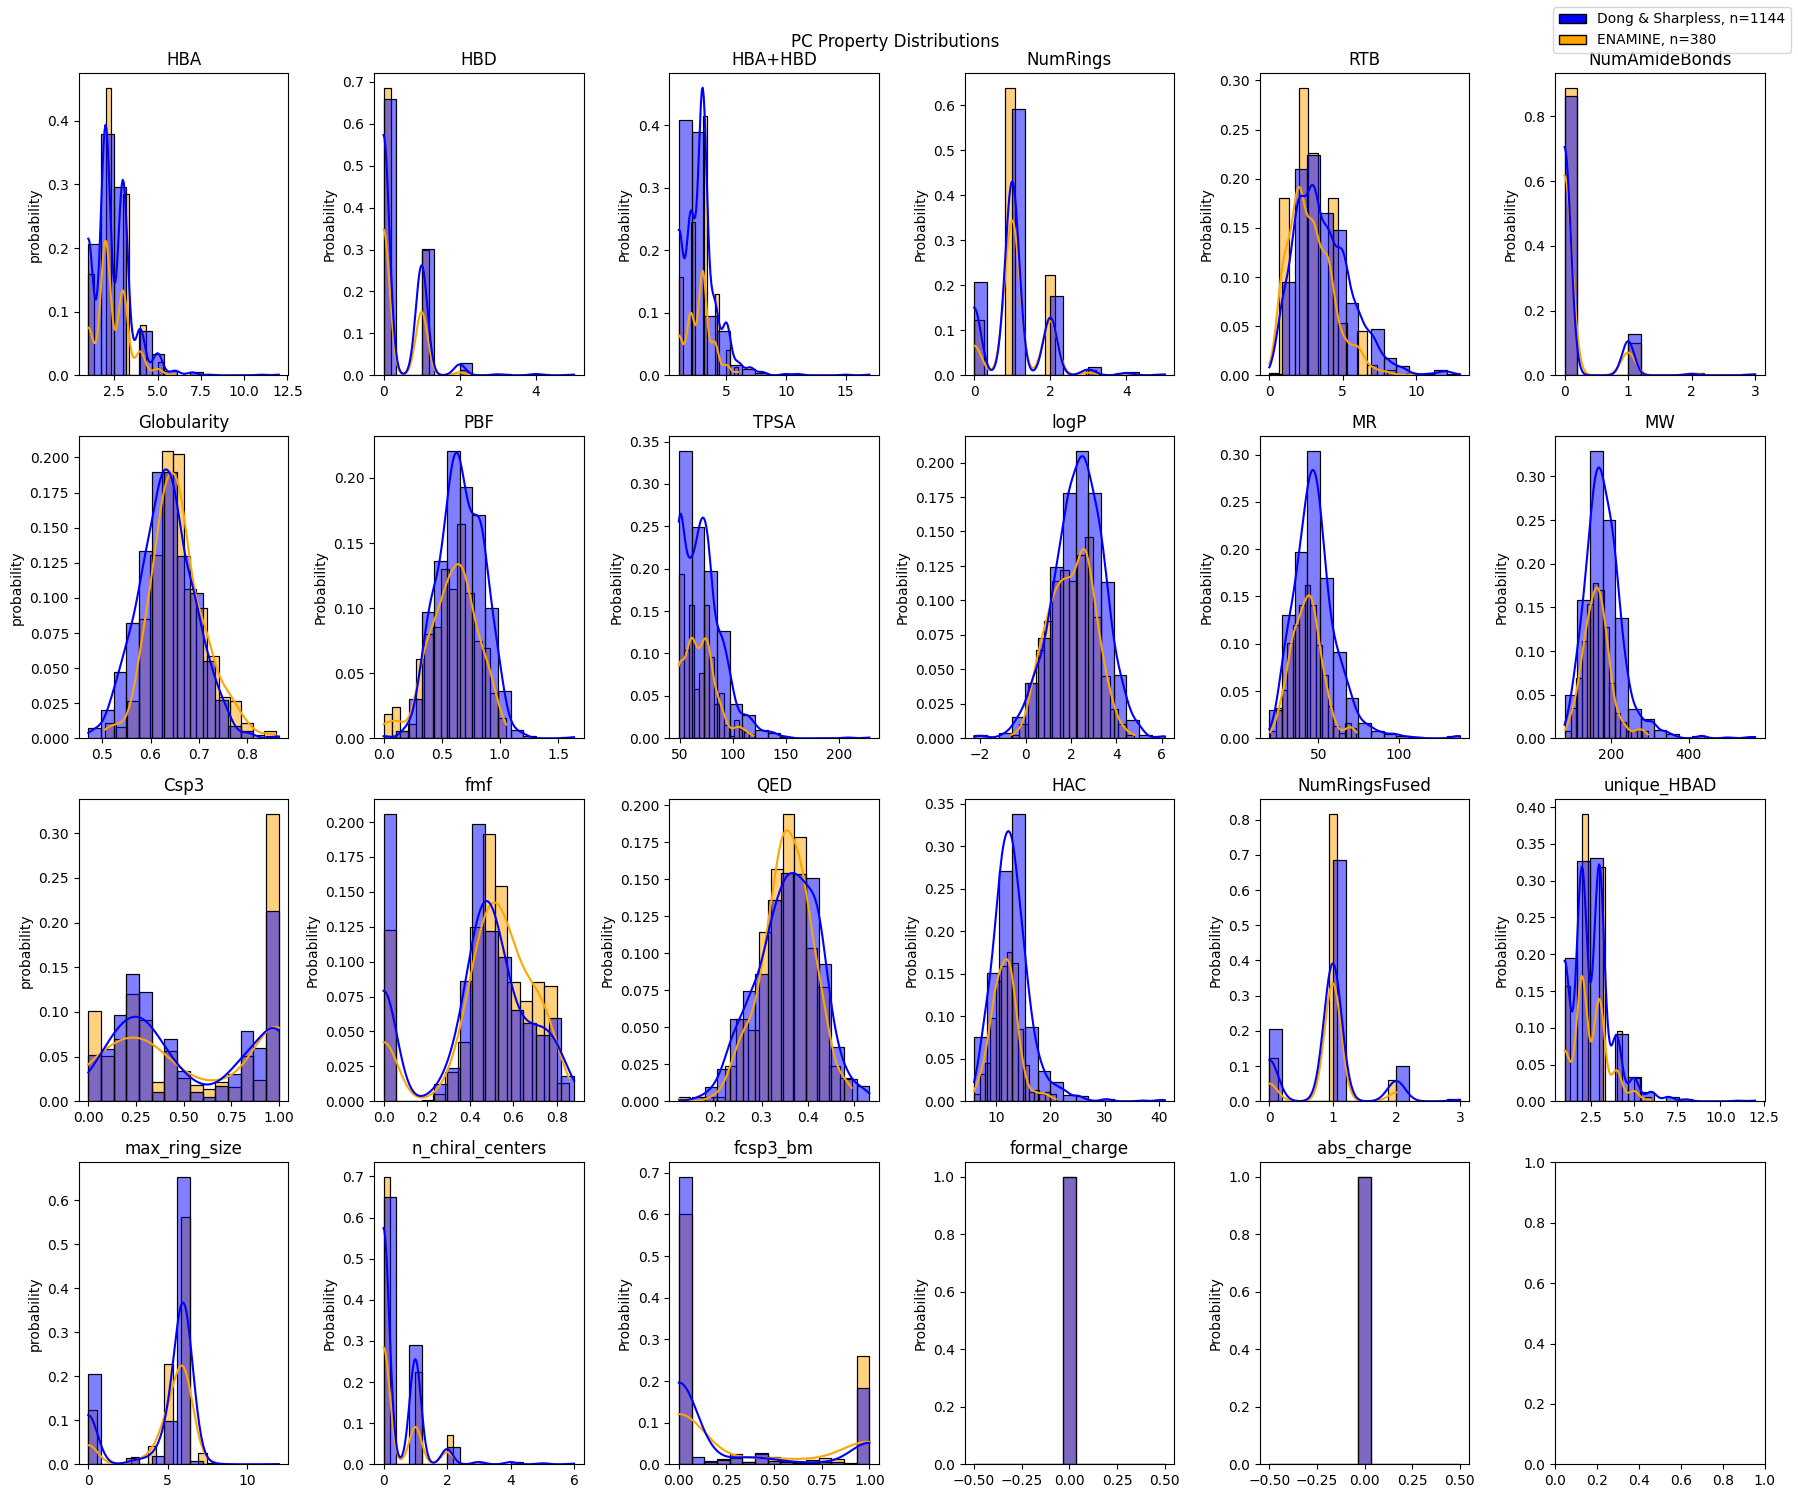

In [9]:
import numpy.ma as ma
plt.rcParams['font.size'] = 10
fig, axs = plt.subplots(4,6, figsize=(18, 15))
fig.suptitle('PC Property Distributions')

for i, prop_name in enumerate(comprehensive_data['40']['props'].keys()):
    
    row = i // 6
    col = i % 6
    print(i, prop_name, row, col)
    X = comprehensive_data['380']['props'][prop_name]
    y = comprehensive_data['380']['mtb_old_resid_std']
    sns.histplot(X, kde=True, ax=axs[row, col], color='orange', alpha=0.5, stat='probability', bins=15)
    X = comprehensive_data['1200']['props'][prop_name]
    y = comprehensive_data['1200']['mtb_old_resid_std']
    sns.histplot(X, kde=True, ax=axs[row, col], color='blue', alpha=0.5, stat='probability', bins=15)

    axs[row, col].set_title(prop_name)
    if col == 0:
        axs[row, col].set_ylabel('probability')
legend_elements = [Patch(facecolor='blue', edgecolor='black',label='Dong & Sharpless, n='+str(len(comprehensive_data['1200']['Smiles']))),
                   Patch(facecolor='orange', edgecolor='black',label='ENAMINE, n='+str(len(comprehensive_data['380']['Smiles']))),
                   ]
fig.legend(handles=legend_elements)
fig.tight_layout()
    

mtb_old_resid_std: 40
msm_old_resid_std: 40
HBA: 39
HBD: 39
HBA+HBD: 39
NumRings: 39
RTB: 39
NumAmideBonds: 39
Globularity: 39
PBF: 39
TPSA: 39
logP: 39
MR: 39
MW: 39
Csp3: 39
fmf: 39
QED: 39
HAC: 39
NumRingsFused: 39
unique_HBAD: 39
max_ring_size: 39
n_chiral_centers: 39
fcsp3_bm: 39
formal_charge: 39
abs_charge: 39
Error: All arrays must be of the same length
False


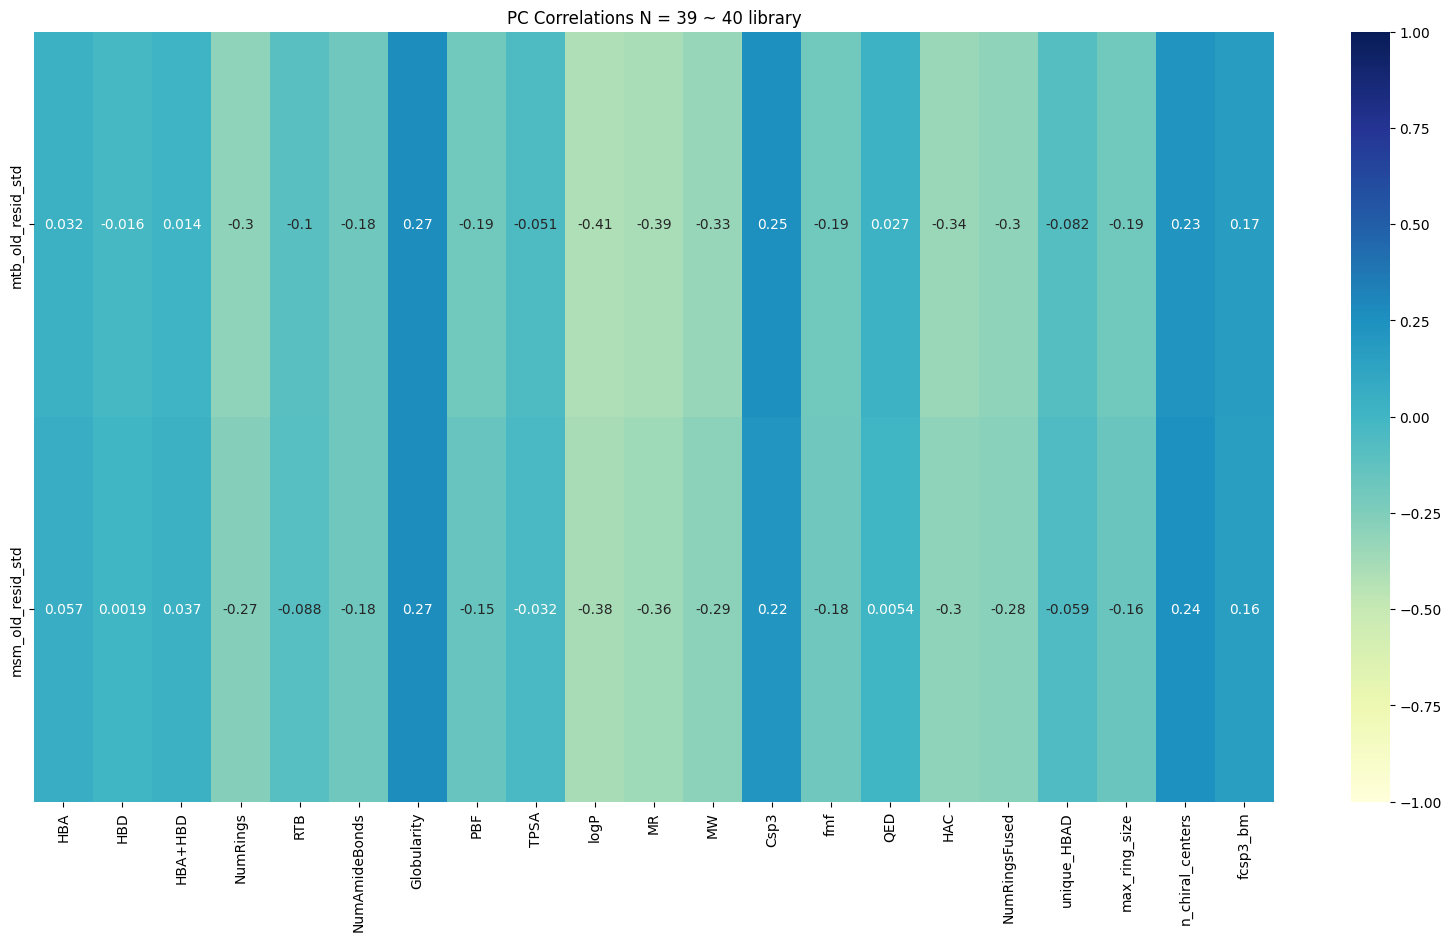

NameError: name 'top_3' is not defined

In [8]:
# Debugging lengths
raw_data = {
    'mtb_old_resid_std': comprehensive_data['40']['mtb_old_resid_std'], 
    'msm_old_resid_std': comprehensive_data['40']['msm_old_resid_std']
}

for prop_name, prop in comprehensive_data['40']['props'].items():
    raw_data[prop_name] = prop

# Check lengths of all columns
for key, value in raw_data.items():
    print(f"{key}: {len(value)}")

# Convert to DataFrame
try:
    raw_data = pd.DataFrame(raw_data).dropna()
except ValueError as e:
    print(f"Error: {e}")
    # Truncate longer columns to the shortest column length
    min_length = min(len(v) for v in raw_data.values())
    raw_data = {k: v[:min_length] for k, v in raw_data.items()}
    raw_data = pd.DataFrame(raw_data).dropna()

print(raw_data.isnull().values.any())
corr = raw_data.corr()

# Plot the correlation heatmap
ax = plt.axes()
dataplot = sns.heatmap(corr.iloc[0:2, 2:-2], cmap="YlGnBu", annot=True, ax=ax, vmin=-1, vmax=1)
plt.title('PC Correlations N = '+ str(len(raw_data['msm_old_resid_std']))+ ' ~ 40 library')
plt.show()

# Top 3 correlations
print(top_3(corr.iloc[0:2, 2:-2]))
print(corr.iloc[0, 2:-2].abs().sum())


mtb_old_resid_std: 380
msm_old_resid_std: 380
HBA: 376
HBD: 376
HBA+HBD: 376
NumRings: 376
RTB: 376
NumAmideBonds: 376
Globularity: 376
PBF: 376
TPSA: 376
logP: 376
MR: 376
MW: 376
Csp3: 376
fmf: 376
QED: 376
HAC: 376
NumRingsFused: 376
unique_HBAD: 376
max_ring_size: 376
n_chiral_centers: 376
fcsp3_bm: 376
formal_charge: 376
abs_charge: 376
Error: All arrays must be of the same length
False


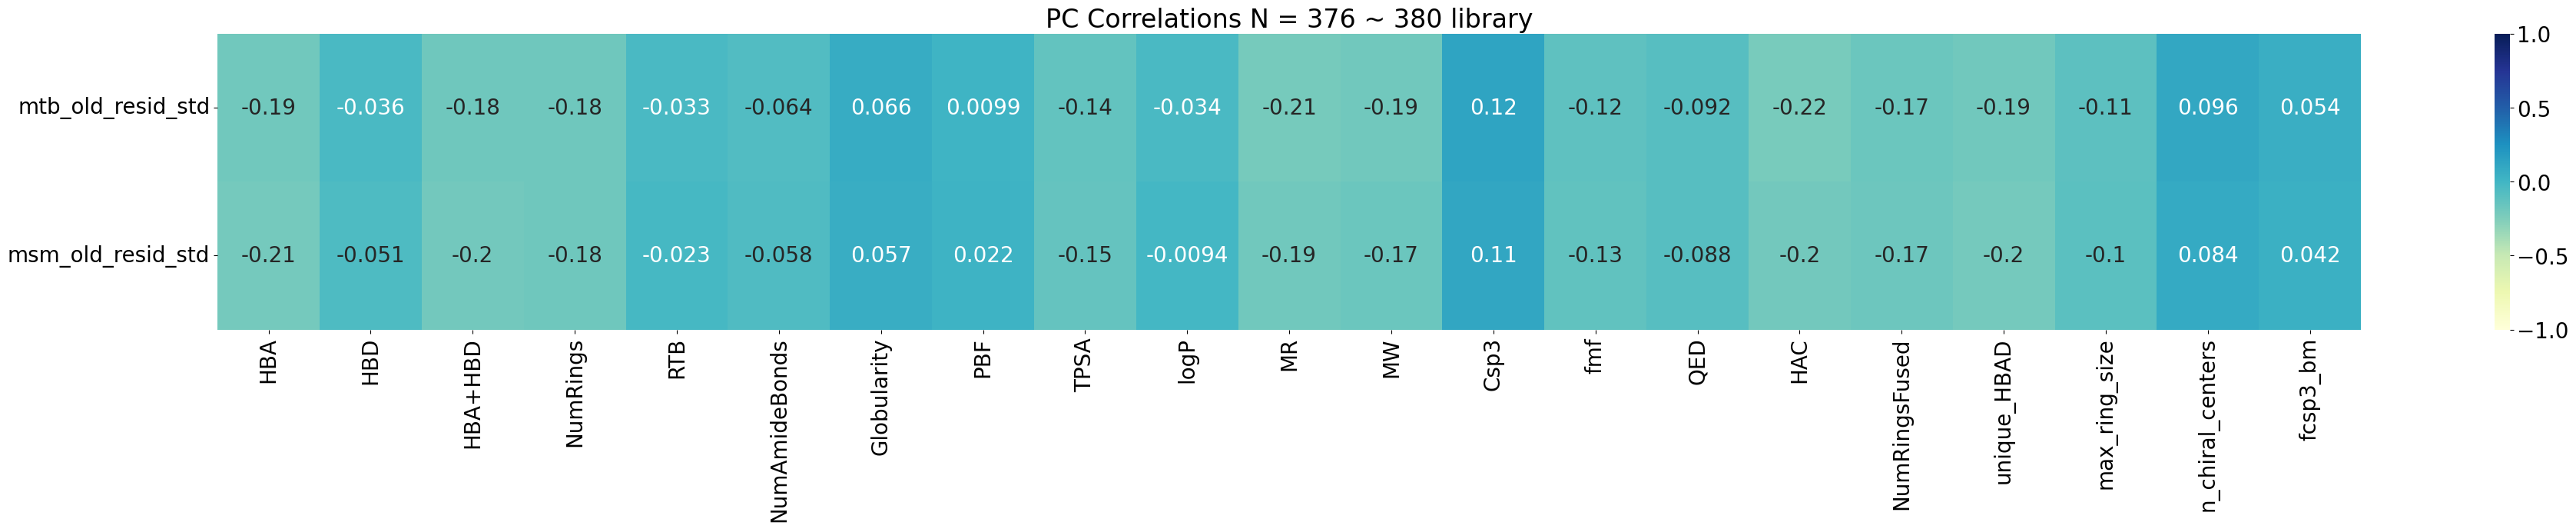

['HAC', 'MR', 'HBA']
2.516878969719181


In [14]:
# Debugging lengths
raw_data = {
    'mtb_old_resid_std': comprehensive_data['380']['mtb_old_resid_std'], 
    'msm_old_resid_std': comprehensive_data['380']['msm_old_resid_std']
}

for prop_name, prop in comprehensive_data['380']['props'].items():
    raw_data[prop_name] = prop

# Check lengths of all columns
for key, value in raw_data.items():
    print(f"{key}: {len(value)}")

# Convert to DataFrame
try:
    raw_data = pd.DataFrame(raw_data).dropna()
except ValueError as e:
    print(f"Error: {e}")
    # Truncate longer columns to the shortest column length
    min_length = min(len(v) for v in raw_data.values())
    raw_data = {k: v[:min_length] for k, v in raw_data.items()}
    raw_data = pd.DataFrame(raw_data).dropna()

print(raw_data.isnull().values.any())
corr = raw_data.corr()

# Plot the correlation heatmap
ax = plt.axes()
dataplot = sns.heatmap(corr.iloc[0:2, 2:-2], cmap="YlGnBu", annot=True, ax=ax, vmin=-1, vmax=1)
plt.title('PC Correlations N = '+ str(len(raw_data['msm_old_resid_std']))+ ' ~ 380 library')
plt.show()

# Top 3 correlations
print(top_3(corr.iloc[0:2, 2:-2]))
print(corr.iloc[0, 2:-2].abs().sum())


mtb_old_resid_std: 1144
msm_old_resid_std: 1144
HBA: 1141
HBD: 1141
HBA+HBD: 1141
NumRings: 1141
RTB: 1141
NumAmideBonds: 1141
Globularity: 1141
PBF: 1141
TPSA: 1141
logP: 1141
MR: 1141
MW: 1141
Csp3: 1141
fmf: 1141
QED: 1141
HAC: 1141
NumRingsFused: 1141
unique_HBAD: 1141
max_ring_size: 1141
n_chiral_centers: 1141
fcsp3_bm: 1141
formal_charge: 1141
abs_charge: 1141
Error: All arrays must be of the same length
False


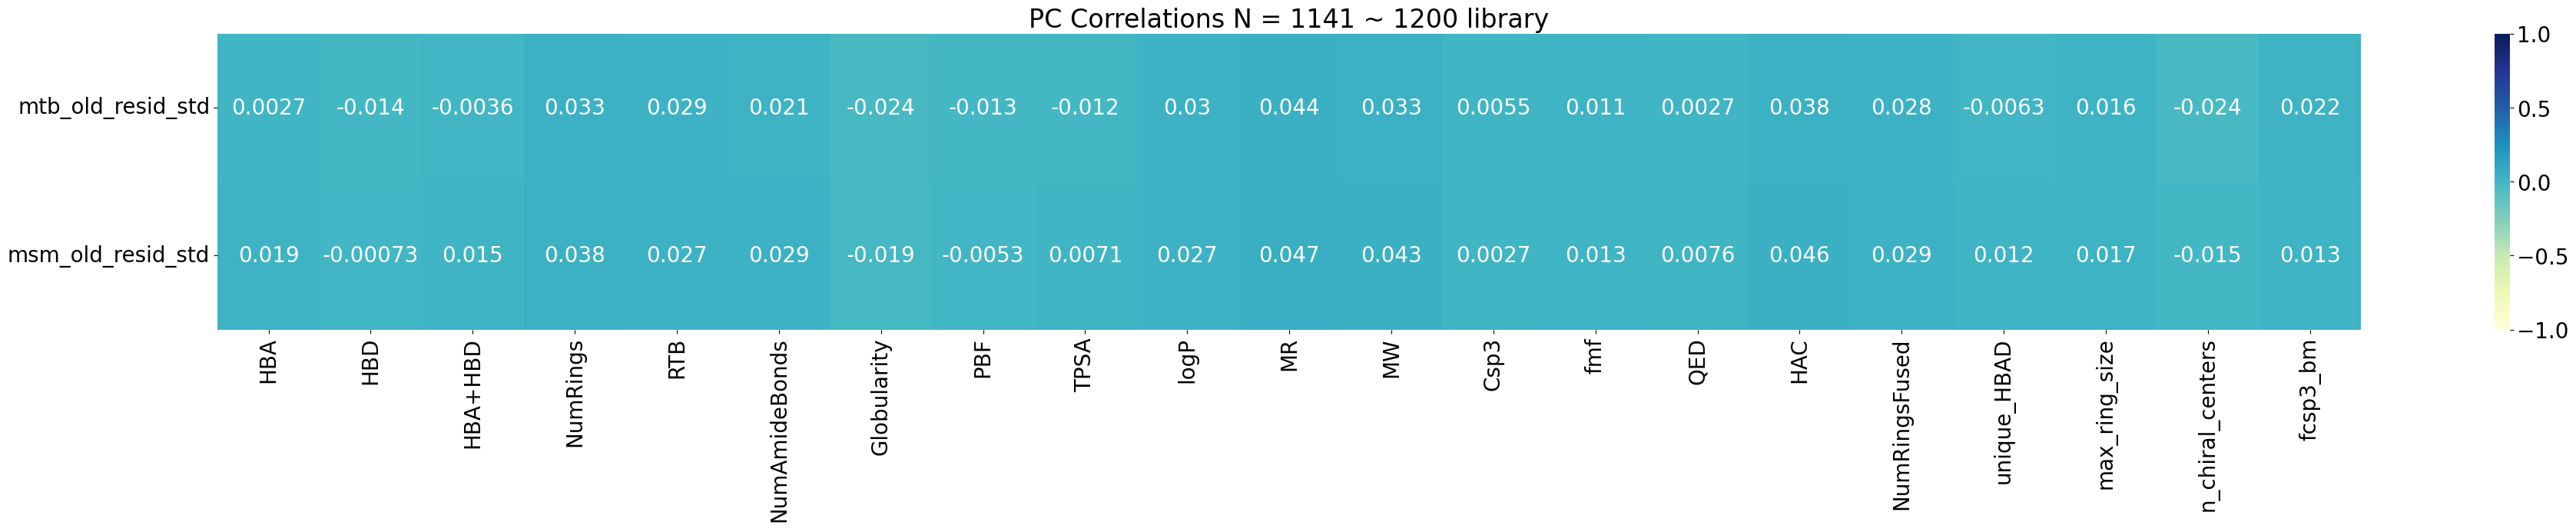

['MR', 'HAC', 'MW']
0.41282745795428244


In [15]:
# Debugging lengths
raw_data = {
    'mtb_old_resid_std': comprehensive_data['1200']['mtb_old_resid_std'], 
    'msm_old_resid_std': comprehensive_data['1200']['msm_old_resid_std']
}

for prop_name, prop in comprehensive_data['1200']['props'].items():
    raw_data[prop_name] = prop

# Check lengths of all columns
for key, value in raw_data.items():
    print(f"{key}: {len(value)}")

# Convert to DataFrame
try:
    raw_data = pd.DataFrame(raw_data).dropna()
except ValueError as e:
    print(f"Error: {e}")
    # Truncate longer columns to the shortest column length
    min_length = min(len(v) for v in raw_data.values())
    raw_data = {k: v[:min_length] for k, v in raw_data.items()}
    raw_data = pd.DataFrame(raw_data).dropna()

print(raw_data.isnull().values.any())
corr = raw_data.corr()

# Plot the correlation heatmap
ax = plt.axes()
dataplot = sns.heatmap(corr.iloc[0:2, 2:-2], cmap="YlGnBu", annot=True, ax=ax, vmin=-1, vmax=1)
plt.title('PC Correlations N = '+ str(len(raw_data['msm_old_resid_std']))+ ' ~ 1200 library')
plt.show()

# Top 3 correlations
print(top_3(corr.iloc[0:2, 2:-2]))
print(corr.iloc[0, 2:-2].abs().sum())
